# GBM Science Data: Time History Spectra

The primary science data produced by GBM can be summarized as a time history of spectra, which is provided temporally pre-binned (CTIME and CSPEC) or temporally unbinned (TTE). These data types are produced as "snippets" for every single trigger and are also provided continuously.  CTIME and CSPEC are provided in daily chunks, and TTE are provided in hourly chunks (since late 2012).  One of the most common things that a user of GBM data wants to do is look at this data (what we call a lightcurve) for one or more detectors over some energy range. The GBM Data Tools provides high-level functions to enable easy reading and plotting of the GBM data as well as fine-grained functions that expose a variety of attributes and operations for the more advanced user.


## CTIME/CSPEC data
The CTIME and CSPEC data are temporally pre-binned data, which have 8 and 128 energy channels respectively.  Our "Hello, World!" for the GBM Data Tools is successfully opening/reading one of these files.

In [1]:
#### our test data directory
from gbm import test_data_dir
# import the CTIME and CSPEC data classes
from gbm.data import Ctime, Cspec

# read a ctime file
ctime = Ctime.open(test_data_dir+'/glg_ctime_nb_bn120415958_v00.pha')
print(ctime)

glg_ctime_nb_bn120415958_v00.pha


Since GBM uses the FITS format, the data files have multiple data extensions, each with metadata information in a "header."  There is also a primary header that contains metadata relevant to the overall file. You can access this metadata information:

In [2]:
# list the headers in the file
ctime.headers.keys()

odict_keys(['PRIMARY', 'EBOUNDS', 'SPECTRUM', 'GTI'])

In [3]:
# print the metadata in the PRIMARY header
ctime.headers['PRIMARY']

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CREATOR = 'GBM_SCI_Reader.pl v1.19' / Software and version creating file        
FILETYPE= 'PHAII   '           / Name for this type of FITS file                
FILE-VER= '1.0.0   '           / Version of the format for this filetype        
TELESCOP= 'GLAST   '           / Name of mission/satellite                      
INSTRUME= 'GBM     '           / Specific instrument used for observation       
DETNAM  = 'NAI_11  '           / Individual detector name                       
OBSERVER= 'Meegan  '        

You can access the values in the headers using the traditional [```astropy.fits.io```](https://docs.astropy.org/en/stable/io/fits/) syntax, There is also easy access for certain important properties:

In [4]:
# certain useful properties are easily accessible
print("GTI: {}".format(ctime.gti))  # the good time intervals for the data
print("Trigger time: {}".format(ctime.trigtime))
print("Time Range: {}".format(ctime.time_range))
print("Energy Range: {}".format(ctime.energy_range))
print('# of Energy Channels: {}'.format(ctime.numchans))

GTI: [(-899.3424419760704, 1000.8578699827194)]
Trigger time: 356223561.133346
Time Range: (-899.3424419760704, 1000.8578699827194)
Energy Range: (4.323754, 2000.0)
# of Energy Channels: 8


The CTIME/CSPEC data objects are modeled as wrappers around the [Data Primitives](./DataPrimitives.ipynb) in ```gbm.data.primitives```, and the underlying data can be accessed via the ```.data``` attribute:

In [5]:
ctime.data

Most casual users need not directly worry about the Data Primitives, though.  The CTIME/CSPEC data objects contain the high-level functionality to perform a lot of common data reduction.  For example, if we only want to work with a short time segment of data in the file, we can take a slice of the data and return a new fully-functional data object with the time-sliced data:

In [6]:
# slice from approx. -10 to +10 s
time_sliced_ctime = ctime.slice_time((-10.0, 10.0))
time_sliced_ctime.time_range

(-10.240202009677887, 10.048128008842468)

Or you can take a slice of the data in energy:

In [7]:
# slice from ~50 keV to ~300 keV
energy_sliced_ctime = ctime.slice_energy((50.0, 300.0))
energy_sliced_ctime.energy_range

(49.60019, 538.1436)

As mentioned, this data is 2-dimensional, so what do we do if we want a lightcurve covering a particular energy range?  You would integrate (sum) over energy, and you can easily do this with the ```to_lightcurve()``` method:

In [8]:
# integrate over the full energy range
lightcurve = ctime.to_lightcurve()

# the lightcurve bin centroids and count rates
lightcurve.centroids, lightcurve.rates

(array([-899.21444198, -898.95853901, -898.70263603, ..., 1000.21786997,
        1000.47386995, 1000.72986996]),
 array([   0.    , 1186.1779, 1596.2815, ..., 1168.0736, 1136.9364,
        1160.156 ], dtype=float32))

In [9]:
# integrate over 50-300 keV
lightcurve = ctime.to_lightcurve(energy_range=(50.0, 300.0))
# the lightcurve bin centroids and count rates
lightcurve.centroids, lightcurve.rates

(array([-899.21444198, -898.95853901, -898.70263603, ..., 1000.21786997,
        1000.47386995, 1000.72986996]),
 array([  0.     , 223.88126, 439.27155, ..., 466.4455 , 380.28564,
        437.49994], dtype=float32))

"Ok, that's cool, but how do I make a plot of the lightcurve?"  To do that, you need to import the ```Lightcurve``` class from the ```gbm.plot``` module:

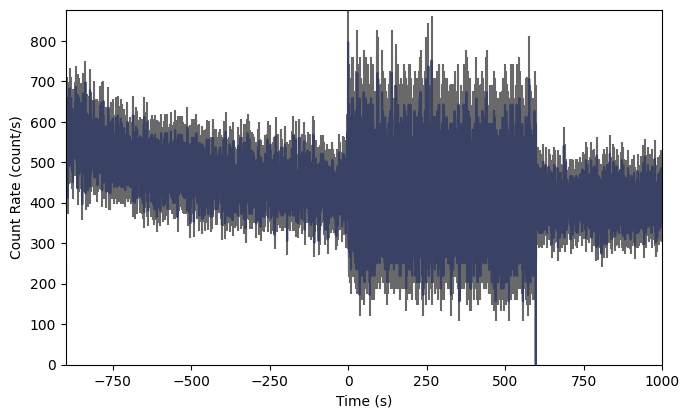

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from gbm.plot import Lightcurve
lcplot = Lightcurve(data=lightcurve)
plt.show()

What...is going on there?  Well, we are reading a trigger CTIME file, so normally the CTIME data is accumulated in 256 ms duration bins, but starting at trigger time, the data switches to 64 ms duration bins for several hundred seconds, and then it goes back to 256 ms bins.

So maybe the native CTIME resolution is overkill because it's hard to see the signal.  If only we could rebin the data to a lower resolution...

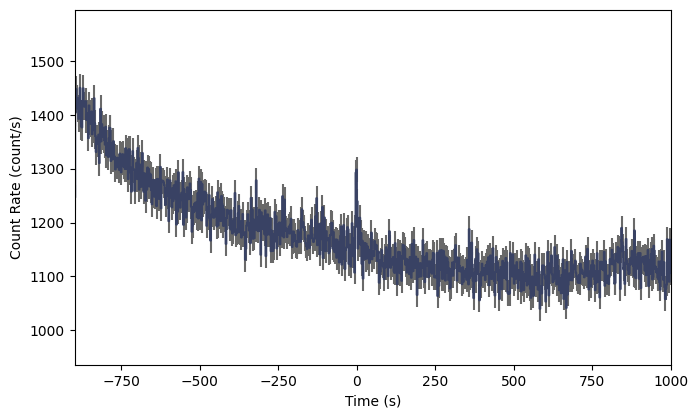

In [11]:
# the data binning module
from gbm.binning.binned import rebin_by_time

# rebin the data to 2048 ms resolution
rebinned_ctime = ctime.rebin_time(rebin_by_time, 2.048)

# and replot
lcplot = Lightcurve(data=rebinned_ctime.to_lightcurve())

And voila!  We can now easily see the GRB signal in the lightcurve,  Of course you'd probably want to zoom in to see it better, but we will talk about the plotting functionality a little later.  If you are working in ipython, you can make these plots interactively, zooming and panning to your heart's content.

You can also just as easily create a count spectrum (integrating over time):

In [12]:
# integrate over the full time range
spectrum = ctime.to_spectrum()
# the energy channel centroids and differential count rates
spectrum.centroids, spectrum.rates

(array([   7.04047 ,   17.340723,   36.069298,   70.78455 ,  171.29333 ,
         395.36002 ,  732.5708  , 1412.2628  ], dtype=float32),
 array([ 8.58324638, 21.62204574,  9.88407582,  3.26465078,  1.09189102,
         0.2609349 ,  0.10644744,  0.07470517]))

In [13]:
# integrate over the time range (-10.0, +10.0)
spectrum = ctime.to_spectrum(time_range=(-10.0, 10.0))
# the energy channel centroids and differential count rates
spectrum.centroids, spectrum.rates

(array([   7.04047 ,   17.340723,   36.069298,   70.78455 ,  171.29333 ,
         395.36002 ,  732.5708  , 1412.2628  ], dtype=float32),
 array([ 8.63882267, 22.40915926, 10.84130467,  3.48270155,  1.08284141,
         0.23386863,  0.10268272,  0.06447497]))

And the corresponding plot for the count spectrum can be made using the ```Spectrum``` class from the ```gbm.plot``` model thusly:

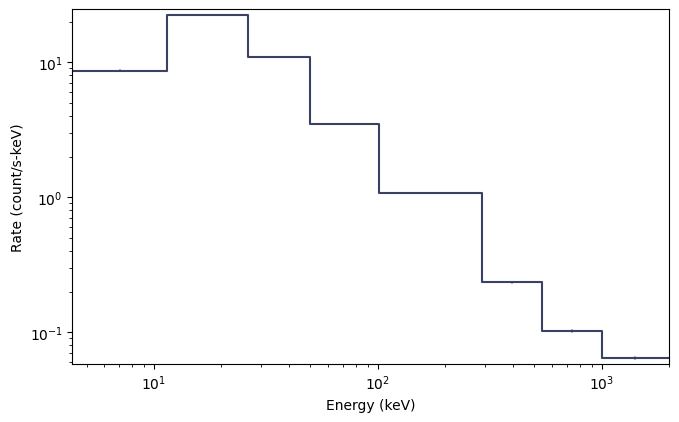

In [14]:
from gbm.plot import Spectrum
specplot = Spectrum(data=spectrum)
plt.show()

Ok, so maybe not quite as interesting as the lightcurve, since CTIME is only 8-channel data after all.  The count spectra for CSPEC and TTE are much prettier. It's worth noting here that this spectrum is integrated over the full duration of the data, so perhaps you are interesting in a particular time range of data.  You can make a single-spectrum PHA object like this:

In [15]:
# integrate over a single time selection
pha1 = ctime.to_pha(time_ranges=[(-10.0, 10.0)])
# integrate over multiple time selections
pha2 = ctime.to_pha(time_ranges=[(-10.0, 10.0), (20.0, 30.0)])

Let's revisit our time-sliced CTIME object.  Maybe we are doing some sort of analysis using the GBM continuous data and we don't want to save the full day's worth of data for our analysis.  We can write our sliced CTIME object to a fully-qualified FITS file following:
```python 
time_sliced_ctime.write('./', filename='my_first_custom_ctime.pha')
```

Everything that we've done here with a CTIME data can be done with CSPEC data by simply using ```Cspec.open()``` instead of ```Ctime.open()``` 

Now to learn about GBM TTE data head, on over to [here](./TteData.ipynb).